In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sranodec as sr
import glob 
from scipy import signal

In [4]:
data_path = "../data-sets/KDD-Cup/data/*"
path_list = glob.glob(data_path)
file_names = {p.split("data/")[1].split("_")[0] : p  for p in path_list}
file_ids = sorted(list(file_names.keys()))

In [6]:
file_path = file_names["090"]
data = pd.read_csv(file_path, sep=",", header=None, names=["orig"])
print(len(data))

128767


In [5]:
def read_data(file_id):
    
    file_path = file_names[file_id]
    
    if file_id in ["204","205", "206", "207", "208", "225","226", "242", "243"]:
        data = pd.read_csv(file_path, sep="\s+", header=None)
        data = data.T
        data.columns = ["orig"]
    else:
        data = pd.read_csv(file_path, sep=",", header=None, names=["orig"])

    point = int(file_path.split("_")[-1].split(".txt")[0])
    train = data.iloc[:point].reset_index(drop=True)
    test  = data.iloc[point:].reset_index(drop=True)
    
    return data, train, test, point

In [85]:
def smoothing(arr, w, padding_len=3):
    """
    @param arr: a pandas series
    @param w: window size
    @param padding_len: default to be 3
    return the smoothing scores
    """
    padding = w * padding_len
    arr = pd.DataFrame(arr, columns=["metric"])

    arr['mask'] = 0.0
    arr.loc[arr.index[w:-w-padding], 'mask'] = 1.0
    arr['mask'] = arr['mask'].rolling(padding, min_periods=1).sum() / padding
    arr["score"] = arr["metric"].rolling(window=w).mean() * arr['mask']
        
    return arr["score"]

In [47]:
def compute_confidence_score(s, w, split_point):
    """
    @param s: score dataframe
    @param name: name of the score 
    @param w: window _size
    @param split_point: index splitting train and test time series
    return the ratio of first peak and second peak
    """
    y = s
    
    # find local maximum
    local_max = (y == y.rolling(window=w).max())
    y.loc[~local_max] = np.nan
    idx_1 = y.idxmax()
    peak_1 = y.max()
    
    # no local maximum
    if not np.isfinite(peak_1):
        print("The value of the first peak is infinite")
        return None, None, None
    else:
        # the maximum is not in test set
        begin = idx_1 - w
        end = idx_1 + w
        if begin < split_point:
            print("The first peak does not locate in the test set")
            return None, None, None
        else:
            # find peak_2 except for this interval [peak_1 - w, peak_1 + w)
            y.iloc[begin:end] = np.nan
            
            idx_2 = y.idxmax()
            peak_2 = y.max()
            
            # if the second height is 0, skip
            if peak_2 == 0. or np.isnan(peak_2):
                print("The second peak's height is 0 or nan")
                return None, None, None
            else:
                ratio = peak_1 / peak_2
                
    return ratio, idx_1, peak_1

In [125]:
def plot_anomaly(data, file_id, split_point, path, begin=0, end=None, save_fig=False) -> None:
    """
    plot the anomaly point against the whole time series data
    @param data: whole time series
    @param result_df: store the confidence, idx of peak, and peak values
    @param split_point: point to split the train and test set
    """
    if end is None:
        end = len(data) - 1
    
    result = pd.read_csv("%s/%s.csv" % (path, file_id))
    anomaly_p = result["idx"][0] 

    plt.figure(figsize=(20,4))
    plt.plot(np.arange(end - begin), data["orig"][begin:end])
    
    if begin == 0:
        plt.axvline(x=split_point, ls=":", label="train test split at %d" % split_point, c = "b")
        plt.legend()
        
    plt.plot(anomaly_p - begin, data.loc[anomaly_p, "orig"],'o')
    plt.title("%s - Anomaly Point, from %d to %d" % (file_id, begin, end))
    
    if save_fig:
        plt.savefig("../picture/%s_anomaly.jpg" % file_id)
    plt.show()
    plt.close()
    
    return result

In [8]:
# increase the window size from 40 to 767, at a rate of 10%

min_window_size = 40
max_window_size = 800
growth_rate = 1.1

# number of different window size
size = int(np.log(max_window_size / min_window_size) / np.log(growth_rate)) + 1
rates = np.full(size, growth_rate) ** np.arange(size)

candidate_d = list(map(int, min_window_size * rates))

In [105]:
def spectral_residual(arr: pd.DataFrame, name: str, ws: int, split_point: int) -> tuple:
    """
    use spectral residual method to find the anomaly
    """
    # same as the period
    series_window_size = ws
    # less than period
    amp_window_size = int(series_window_size / 1.1)
    # a number enough larger than period
    score_window_size= 2 * series_window_size
    spec = sr.Silency(amp_window_size, series_window_size, score_window_size)
    score = spec.generate_anomaly_score(arr[name].values)
    score = smoothing(score, ws)
    conf, idx, peak = compute_confidence_score(score, ws, split_point)
    return conf, idx, peak

In [111]:
for file_id in file_ids[:10]:
    
    data, _, _, point = read_data(file_id)
    data["diff"] = data["orig"].diff(1).fillna(method="bfill")
    data["acc"] = data["diff"].diff(1).fillna(method="bfill")
    
    sr_dict = {}

    for w in candidate_d:

        conf, idx, peak = spectral_residual(data, "orig", w, point)
        sr_dict["%d, sr_orig" % w] = {"confidence": conf, "idx": idx, "peak": peak} 

        conf, idx, peak = spectral_residual(data, "diff", w, point)
        sr_dict["%d, sr_diff" % w] = {"confidence": conf, "idx": idx, "peak": peak} 

        conf, idx, peak = spectral_residual(data, "acc", w, point)
        sr_dict["%d, sr_acc" % w] = {"confidence": conf, "idx": idx, "peak": peak} 

    sr_df = pd.DataFrame.from_dict(sr_dict, orient="index")
    sr_df = sr_df[~sr_df["idx"].isna()].sort_values(["confidence"], ascending=False)
    
    sr_df.to_csv("../sr_results/%s.csv" % file_id, header=True, index=True)

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double

In [134]:
file_id = "003"
data, _, _, point = read_data(file_id)

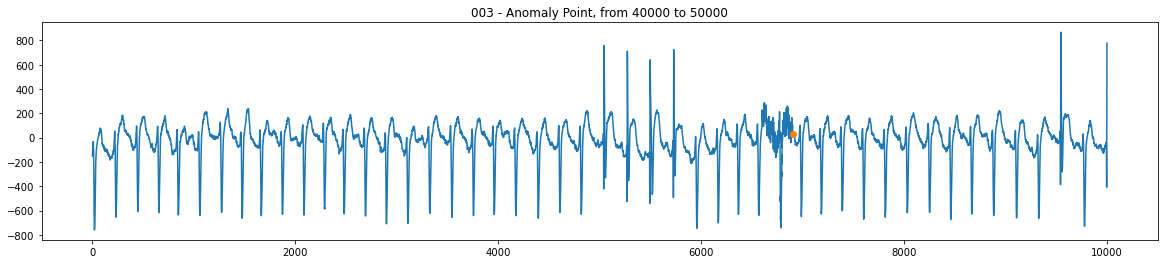

     Unnamed: 0  confidence      idx      peak
0  433, sr_orig    5.417967  46901.0  2.795906
1  393, sr_orig    5.337351  46901.0  2.905601
2   433, sr_acc    5.253745  46902.0  2.954450


In [135]:
begin = 40000
end = 50000

path = "../sr_results"
result = plot_anomaly(data, file_id, point, path, begin=begin, end=end, save_fig=False)
print(result.head(3))

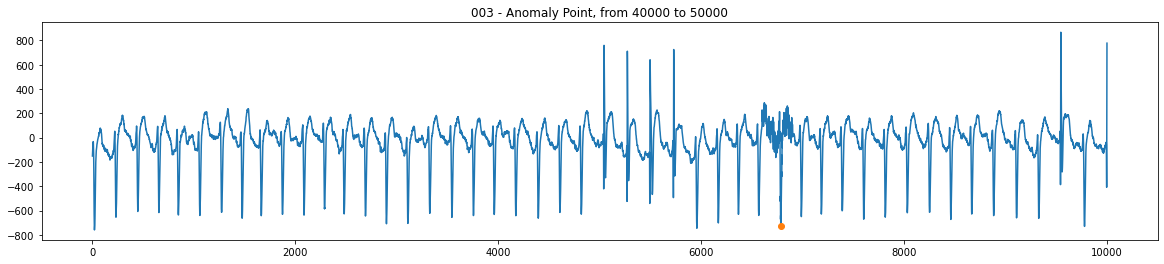

        Unnamed: 0  confidence      idx        peak
0  ws=244, acc_std    2.080101  46784.0  121.589589


In [132]:
begin = 40000
end = 50000

path = "../results"
result = plot_anomaly(data, file_id, point, path, begin=begin, end=end, save_fig=False)
print(result.head(1))